In [2]:
%matplotlib inline
import sklearn
import nose
import astroML_addons
import astroML
import scipy
import pandas
import xdgmm
from astropy.io import fits
import csv
import os
from shutil import copyfile
import numpy as np
import matplotlib.pyplot as plt



#xdgmm.read_model('galaxyTrialSet'+datestr+'.fit')
xdgmmG = xdgmm.XDGMM(filename='galaxyTrialSet2018-03-22.fit')

#xdgmm.save_model('notNullTrialset_feb15.fit')
xdgmmQ = xdgmm.XDGMM(filename='notNullTrialset_feb15.fit')

print("Galaxy weights:")
print(xdgmmG.weights)
print("Quasar weights:")
print(xdgmmQ.weights)

Galaxy weights:
[  1.30442655e-01   1.31654676e-01   2.15592659e-01   5.49861817e-03
   2.13396564e-01   2.77492505e-02   3.23011640e-02   2.43127793e-01
   2.36619802e-04]
Quasar weights:
[ 0.35075201  0.16394932  0.32481524  0.0415381   0.11894532]


running
Epoch: 1
525
Error count: 0
Length of w1: 526
deltaW length225
name length225
[68]
[216]
Epoch: 2
525


//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:143: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
//anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:146: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


Error count: 0
Length of w1: 526
deltaW length216
name length216
[60]
Epoch: 3
525
Error count: 0
Length of w1: 526
deltaW length214
name length213
[204]
Epoch: 4
525
Error count: 0
Length of w1: 526
deltaW length230
name length230
[67]
Epoch: 5
525
Error count: 0
Length of w1: 526
deltaW length228
name length228
[62]
Epoch: 6
525
Error count: 0
Length of w1: 526
deltaW length234
name length233
[184]
Epoch: 7
525
Error count: 0
Length of w1: 526
deltaW length238
name length237
[70]
[125]
Epoch: 8
525
Error count: 0
Length of w1: 526
deltaW length228
name length227
Epoch: 9
525
Error count: 0
Length of w1: 526
deltaW length230
name length230
[21]
10
done.


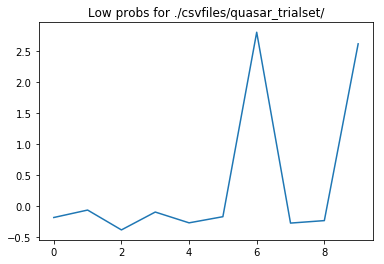

In [102]:
def fetchValsByEpoch(epoch, directorystr):
    
    deltaW = []
    sigW = []
    w1 = []
    w2 = []
    w1s = []
    w2s = []
    mjd = []
    name = []
    

    #directorystr = './csvfiles/galaxy_csvfiles-150318/'
    directory = os.fsencode(directorystr)
    filelist = os.listdir(directory)
    print(len(filelist))
    readdata = np.zeros((22,len(filelist)+1)) #one big list to rule them all
    fileCount = 0 #to keep our place in each list as we go through the files
    blankCount = 0
    for file in filelist:
        filestr = os.fsdecode(file)
        if(filestr.endswith(".csv")):
            readfile = open(directorystr+filestr, 'r')
            #name.append(filestr)
            reader = csv.reader(readfile)
            typeIndex = 0 #to iterate through the w1, w2, etc list
            nullCount = 0
            rowCount = 0
            
            for row in enumerate(reader):
                if rowCount < 5 or rowCount >= 14:
                    if rowCount == 0 and row[1][1] == "null|":
                        #print("Empty csv")
                        nullCount = nullCount + 1 #skip this file
                    rowCount = rowCount + 1
                    continue #skip the first and last rows
                try:
                    entry = row[1][epoch]
                except IndexError:
                    rowCount = rowCount + 1
                    continue
                try:
                    fentry = float(entry)
                    readdata[typeIndex][fileCount] = fentry
                except ValueError:
                    if entry != 'null': #this is a label; skip it
                        print("String!")
                        print(entry)
                        rowCount = rowCount + 1 #keep track of where we are in the file
                        continue #skip to next row, do not increment readdata row
                    else: #this file isn't useful
                        readdata[typeIndex][fileCount] = 99
                        nullCount = nullCount + 1 #this is a null in W1 or W2. don't want this file
                rowCount = rowCount + 1 #move on to the next row in the file
                typeIndex = typeIndex + 1 #move to next row in the data array
            if nullCount == 0:
                fileCount = fileCount + 1 #overwrite if we found null in W1, W2.
                name.append(filestr)
                
                    #break
                
    print("Error count: " + str(blankCount))    
    w1 = [round(float(x), 4) for x in readdata[1]]
    #print(w1)
    w2 = [round(float(x), 4) for x in readdata[3]]
    #print("w2")
    #print(w2)
    w1s = [round(float(x), 4) for x in readdata[2]]
    #print(w1s)
    w2s = [round(float(x), 4) for x in readdata[4]]
    #print(w2s)
    mjd = [float(x) for x in readdata[0]]
    #print(mjd)
    print("Length of w1: " + str(len(w1)))
    #print(name)
   
    
    deltaW = [x - y for x,y in zip(w1,w2)]
    sigW = [np.sqrt(sx**2 + sy**2) for sx,sy in zip(w1s, w2s)]
    
    
    
    #print("deltaW")
    #print(len(deltaW))
    #print(deltaW)
    
    notNullCount = 0
    for val in w1:
        if val != 0:
            notNullCount = notNullCount + 1
    deltaW = deltaW[:notNullCount]
    sigW = sigW[:notNullCount] #trim the array of the extra length
    print("deltaW length" + str(len(deltaW)))
    print("name length" + str(len(name)))
    
    
    
    return deltaW, sigW, notNullCount, name, mjd

def checkProbs(epoch, modelone, modeltwo, directorystr):

    result = fetchValsByEpoch(epoch, directorystr)
    deltaW = result[0]
    sigW = result[1]
    npoints = result[2]
    radec = result[3]
    mjd = result[4]

    deltaW = np.array(deltaW)
    deltaW = deltaW.reshape(deltaW.shape[0], 1)

    sigW = np.array(sigW)
    sigW = sigW.reshape(sigW.shape[0], 1,1)

    tryProb = modelone.score_samples(deltaW, sigW)

    lowprob = [x for x in tryProb[0] if x < -4] #the low values
    
#     for x in tryProb[0]:
#         probModelTwo = modeltwo.score_samples()

    lowprobRADEC = []
    lowDeltaWs = []
    lowSigWs = []
    lowMjds = []
    for lowval in lowprob:
        for val in tryProb[0]:
            if(val == lowval):
                minindex = np.where(tryProb[0] == val) #indices of the low values
                for i in minindex:
                    print(i)
                    if(len(deltaW[i])!=0):
#                         print(deltaW[i][0])
#                         print(sigW[i][0])
#                         print(mjd[i])
                        lowprobRADEC.append(radec[i])
                        lowDeltaWs.append(deltaW[i][0])
                        lowSigWs.append(sigW[i][0])
                        lowMjds.append(mjd[i])
                    else:
                        continue
                    
    if(len(lowDeltaWs) != 0):
        lowDeltaWs = np.array(lowDeltaWs)
        lowSigWs = np.array(lowSigWs)
        return lowprobRADEC, lowDeltaWs, lowMjds
        
#         lowDeltaWs.reshape(lowDeltaWs.shape[0], 1)
#         lowSigWs.reshape(lowSigWs.shape[0], 1, 1)
#         probModeltwo = modeltwo.score_samples(lowDeltaWs, lowSigWs)               
#         return lowprobRADEC, probModeltwo[0]
    else:
        return

print("running")
directorystr = './csvfiles/quasar_trialset/'
model = xdgmmQ #galaxies or quasars?
model2 = xdgmmG




lowProbVals = []
crossmodelprobs = []
names = []
lowDeltaWs = []
lowMjds = []
import subprocess

for epoch in range(1, 10):
    print("Epoch: " + str(epoch))
    #valsOut = checkProbs(epoch, xdgmmQ, directorystr)
    result = checkProbs(epoch, model, model2, directorystr)
    if(result):
        #print(result)
        for i in result[0]:
            names.append(i)
        for i in result[1]:
            lowDeltaWs.append(i[0])
        for i in result[2]:
            lowMjds.append(i)
        
        
#         for i in result[1]:
#             if i > -2:
#                 crossmodelprobs.append(i) #a list of the most cross-model-esque candidates
# plt.plot(crossmodelprobs)
    
    
print(len(names))            
#print(names)

plt.plot(lowDeltaWs)
plt.title("Low probs for " + directorystr)
#print(lowDeltaWs)

print("done.")
#not all files have the same number of observations


In [28]:
f = open('quasar_flags_-4.txt', 'w')
for i in range(len(names)):
    f.write(names[i]+','+str(lowMjds[i])+'\n')
f.close()
print("Done")

Done


(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   2.,
          1.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,
          1.,   0.,   1.,   0.,   1.,   1.,   0.,   1.,   3.,   1.,   1.,
          1.,   3.,   2.,   4.,   3.,   2.,   6.,   4.,   8.,   3.,  11.,
          9.,   9.,  11.,  14.,  14.,   9.,   9.,   3.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0., 

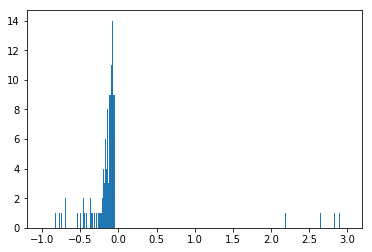

In [33]:
binwidth = 0.01
plt.hist(lowDeltaWs, bins=np.arange(-1, 3, binwidth))